# Unit 5 - Financial Planning

In [1]:
# Initial imports
import os
import requests
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation
import json
%matplotlib inline

In [2]:
# Load .env enviroment variables
load_dotenv()

True

## Part 1 - Personal Finance Planner

### Collect Crypto Prices Using the `requests` Library

In [3]:
# Set current amount of crypto assets
my_btc = 1.2
my_eth = 5.3

In [17]:
# Crypto API URLs
btc_url = "https://api.alternative.me/v2/ticker/Bitcoin/?convert=CAD"
eth_url = "https://api.alternative.me/v2/ticker/Ethereum/?convert=CAD"

btc_url = btc_url + "?format=json"
eth_url = eth_url + "?format=json"

In [18]:
# Fetch current BTC price
btc_price = requests.get(btc_url)

In [19]:
# Fetch current ETH price
eth_price = requests.get(eth_url)

In [20]:
# Retieve output for BTC & ETH to get names of rows
btc_response = btc_price.content
eth_response = eth_price.content


In [21]:
# Convert output to JSON
btc_data = btc_price.json()
eth_data = eth_price.json()

# Fetch Prices of both BTC and ETH to compute value of crypto portfolio
btc_price = btc_data['data']['1']['quotes']['USD']['price']
eth_price = eth_data['data']['1027']['quotes']['USD']['price']


In [22]:
# Compute current value of my crpto

total_btc_value = my_btc * btc_price
total_eth_value = my_eth * eth_price

# Print current crypto wallet balance
print(f"The current value of your {my_btc} BTC is ${total_btc_value:0.2f}")
print(f"The current value of your {my_eth} ETH is ${total_eth_value:0.2f}")

The current value of your 1.2 BTC is $46173.60
The current value of your 5.3 ETH is $14766.07


### Collect Investments Data Using Alpaca: `SPY` (stocks) and `AGG` (bonds)

In [23]:
# Set current amount of shares
my_agg = 200
my_spy = 50

In [24]:
# Set Alpaca API key and secrety'
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# Verify that Alpaca key and secret were correctly loaded
#print(f"Alpaca Key type: {type(alpaca_api_key)}")
#print(f"Alpaca Secret Key: {type(alpaca_secret_key)}")

# Create the Alpaca API object
api = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2"
)

In [25]:
# Format current date as ISO format
today = pd.Timestamp("2020-10-21", tz="America/New_York").isoformat()

# Set the tickers
tickers = ["AGG", "SPY"]

# Set timeframe to '1D' for Alpaca API
timeframe = "1D"

# Get current closing prices for SPY and AGG
# (use a limit=1000 parameter to call the most recent 1000 days of data)
df_portfolio = api.get_barset(
    tickers,
    timeframe,
    start = today,
    end = today,
    limit = 1000
).df

# Preview DataFrame
df_portfolio.head()

AGG                                       SPY  \
                             open    high     low    close   volume    open   
time                                                                          
2020-10-21 00:00:00-04:00  117.59  117.64  117.48  117.515  2910530  343.33   

                                                            
                             high    low   close    volume  
time                                                        
2020-10-21 00:00:00-04:00  345.67  342.4  342.69  46745662

In [26]:
# Pick AGG and SPY close prices
agg_close_price = df_portfolio["AGG"]["close"].item()
spy_close_price = df_portfolio["SPY"]["close"].item()

# Print AGG and SPY close prices
print(f"Current AGG closing price: ${agg_close_price}")
print(f"Current SPY closing price: ${spy_close_price}")

Current AGG closing price: $117.515
Current SPY closing price: $342.69


In [27]:
# Compute the current value of shares
my_spy_value = my_spy * spy_close_price
my_agg_value = my_agg * agg_close_price

# Print current value of shares
print(f"The current value of your {my_spy} SPY shares is ${my_spy_value:0.2f}")
print(f"The current value of your {my_agg} AGG shares is ${my_agg_value:0.2f}")

The current value of your 50 SPY shares is $17134.50
The current value of your 200 AGG shares is $23503.00


### Savings Health Analysis

In [28]:
# Set monthly household income
monthly_income = 12000

# Consolidate financial assets data
total_portfolio_dictionary = {'Amount': [total_btc_value+total_eth_value, my_spy_value+my_agg_value]}

# Create savings DataFrame
df_savings = pd.DataFrame(total_portfolio_dictionary,index=['Crypto','Shares'])

# Display savings DataFrame
display(df_savings)

,Amount
Crypto,60939.665
Shares,40637.500


array([<AxesSubplot:ylabel='Amount'>], dtype=object)

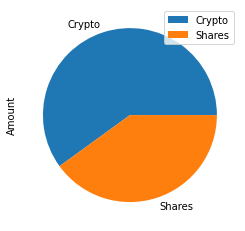

In [29]:
# Plot savings pie chart
df_savings.plot(kind='pie', subplots=True)

In [34]:
# Set ideal emergency fund
emergency_fund = monthly_income * 3

# Calculate total amount of savings
total_savings = df_savings.sum().item()

# Validate saving health
if total_savings > emergency_fund:
    print("Congratulations! You have enough money in your emergency fund.")
elif total_savings == emergency_fund:
    print("Congratulations on reaching your financial goal.")
else:
    print(f'You are ${emergency_fund - total_savings} away from reaching the goal of 3x your monthly income in your emergency fund.')

Congratulations! You have enough money in your emergency fund.


## Part 2 - Retirement Planning

### Monte Carlo Simulation

In [35]:
# Set start and end dates of five years back from today.
# Sample results may vary from the solution based on the time frame chosen
start_date = pd.Timestamp('2016-05-01', tz='America/New_York').isoformat()
end_date = pd.Timestamp('2021-05-01', tz='America/New_York').isoformat()

In [36]:
# Get 5 years' worth of historical data for SPY and AGG
# (use a limit=1000 parameter to call the most recent 1000 days of data)
df_stock_data = api.get_barset(
    tickers,
    timeframe,
    start = start_date,
    end = end_date
).df

# Display sample data
df_stock_data.head()

AGG                                       \
                             open      high       low   close   volume   
time                                                                     
2020-12-07 00:00:00-05:00  117.76  117.8262  117.6900  117.75  4689469   
2020-12-08 00:00:00-05:00  117.88  117.9597  117.7500  117.77  3587353   
2020-12-09 00:00:00-05:00  117.73  117.7800  117.5172  117.62  4720359   
2020-12-10 00:00:00-05:00  117.74  117.9300  117.6900  117.88  4694024   
2020-12-11 00:00:00-05:00  118.01  118.0900  117.9500  118.03  5537449   

                              SPY                                        
                             open      high     low     close    volume  
time                                                                     
2020-12-07 00:00:00-05:00  369.02  369.6200  367.72  369.1200  40456544  
2020-12-08 00:00:00-05:00  367.72  370.7800  367.67  370.1599  32702217  
2020-12-09 00:00:00-05:00  370.88  371.0500  365.95  366.8900  60700254  
2020-12-10 00:00:00-05:00  365.37  367.8600  364.43  366.7200  47851654  
2020-12-11 00:00:00-05:00  364.90  366.7402  363.26  366.2800  47917103

In [41]:
# Configuring a Monte Carlo simulation to forecast 30 years cumulative returns
MC_thirty_year = MCSimulation(
    portfolio_data = df_stock_data,
    weights = [.40, .60],
    num_simulation = 500,
    num_trading_days = 252*30
)

In [42]:
# Printing the simulation input data
MC_thirty_year.portfolio_data.head()

AGG                                       \
                             open      high       low   close   volume   
time                                                                     
2020-12-07 00:00:00-05:00  117.76  117.8262  117.6900  117.75  4689469   
2020-12-08 00:00:00-05:00  117.88  117.9597  117.7500  117.77  3587353   
2020-12-09 00:00:00-05:00  117.73  117.7800  117.5172  117.62  4720359   
2020-12-10 00:00:00-05:00  117.74  117.9300  117.6900  117.88  4694024   
2020-12-11 00:00:00-05:00  118.01  118.0900  117.9500  118.03  5537449   

                                           SPY                              \
                          daily_return    open      high     low     close   
time                                                                         
2020-12-07 00:00:00-05:00          NaN  369.02  369.6200  367.72  369.1200   
2020-12-08 00:00:00-05:00     0.000170  367.72  370.7800  367.67  370.1599   
2020-12-09 00:00:00-05:00    -0.001274  370.88  371.0500  365.95  366.8900   
2020-12-10 00:00:00-05:00     0.002211  365.37  367.8600  364.43  366.7200   
2020-12-11 00:00:00-05:00     0.001272  364.90  366.7402  363.26  366.2800   

                                                  
                             volume daily_return  
time                                              
2020-12-07 00:00:00-05:00  40456544          NaN  
2020-12-08 00:00:00-05:00  32702217     0.002817  
2020-12-09 00:00:00-05:00  60700254    -0.008834  
2020-12-10 00:00:00-05:00  47851654    -0.000463  
2020-12-11 00:00:00-05:00  47917103    -0.001200

In [45]:
# Running a Monte Carlo simulation to forecast 30 years cumulative returns
MC_thirty_year.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


/Users/shanelkuchera/Financial_Planning/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo simulation number 230.
Running Monte Carlo simulation number 240.
Running Monte Carlo simulation number 250.
Running Monte Carlo simulation number 260.
Running Monte Carlo simulation number 270.
Running Monte Carlo simulation number 280.
Running Monte Carlo simulation number 290.
Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 310.
Running Monte Carlo simulation number 320.
Running Monte Carlo simulation number 330.
Running Mon

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.994165,1.002931,0.998586,1.001663,1.002602,0.989003,0.996386,1.006179,1.002422,0.996003,...,0.995916,1.000073,0.999409,0.996084,1.002870,0.999236,1.000861,1.009349,1.000934,1.000766
2,0.999086,1.011308,0.997835,1.008226,0.997851,0.985702,0.991226,1.001406,1.004753,0.996464,...,0.996158,0.998349,0.999036,1.001191,1.003124,0.997535,1.001855,1.006535,1.002375,1.003619
3,0.996169,1.011367,1.004559,1.015816,0.994623,0.988004,0.993587,1.009563,1.005040,0.982916,...,0.993987,0.998664,0.994441,1.006359,1.002932,0.996845,0.999906,0.999846,1.000538,1.004146
4,0.999796,1.009054,0.997572,1.019715,0.999048,0.985476,0.987627,1.013409,1.010892,0.984823,...,0.986146,0.989488,0.993056,1.010816,0.995722,0.993918,0.994491,1.006016,1.005072,1.004460
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7556,144.682681,295.950596,132.439031,168.532585,111.909590,113.827336,64.291639,61.879730,154.076789,262.554491,...,211.061323,74.304863,83.021940,103.941056,176.732501,202.169917,78.015114,77.504751,185.983546,202.505115
7557,144.620002,296.790149,132.786457,167.582391,112.088890,114.029007,63.799605,61.615449,153.459261,262.702627,...,211.681631,75.227884,82.554823,104.058674,176.153051,202.783245,77.994065,77.721761,185.149782,202.635599
7558,144.280133,296.914133,132.988932,166.326575,111.304815,113.884894,64.185326,61.471597,153.791172,263.570317,...,211.765994,75.299312,83.292622,103.579608,176.926651,203.509504,77.766492,78.453877,184.619898,202.299167
7559,144.724089,299.286192,132.969496,165.241387,111.894937,114.087331,63.543335,61.354709,153.415140,265.357716,...,210.909242,75.401844,83.775444,104.016068,176.064844,202.596726,77.779855,78.409092,184.431993,202.423895


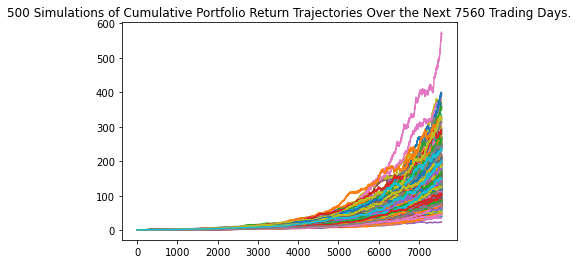

In [47]:
# Plot simulation outcomes
line_plot = MC_thirty_year.plot_simulation()

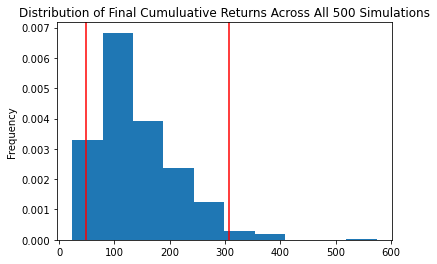

In [48]:
# Plot probability distribution and confidence intervals
dist_plot = MC_thirty_year.plot_distribution()

### Retirement Analysis

In [49]:
# Fetch summary statistics from the Monte Carlo simulation results
tbl = MC_thirty_year.summarize_cumulative_return()

# Print summary statistics
print(tbl)

count           500.000000
mean            140.428120
std              70.765236
min              23.499837
25%              89.278357
50%             123.068214
75%             177.882886
max             574.005529
95% CI Lower     47.814420
95% CI Upper    307.635323
Name: 7560, dtype: float64


### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `$20,000` initial investment.

In [50]:
# Set initial investment
initial_investment = 20000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $20,000
ci_lower = round(tbl[8]*initial_investment,2)
ci_upper = round(tbl[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $20000 in the portfolio over the next 30 years will end within in the range of $956288.4 and $6152706.46


### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `50%` increase in the initial investment.

In [51]:
# Set initial investment
initial_investment = 20000 * 1.5

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $30,000
ci_lower = round(tbl[8]*initial_investment,2)
ci_upper = round(tbl[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $30000.0 in the portfolio over the next 30 years will end within in the range of $1434432.61 and $9229059.68


## Optional Challenge - Early Retirement


### Five Years Retirement Option

In [52]:
# Configuring a Monte Carlo simulation to forecast 5 years cumulative returns
MC_five_year = MCSimulation(
    portfolio_data = df_stock_data,
    weights = [.40,.60],
    num_simulation = 500,
    num_trading_days = 252*5
)

In [53]:
# Running a Monte Carlo simulation to forecast 5 years cumulative returns
MC_five_year.portfolio_data.head()

AGG                                       \
                             open      high       low   close   volume   
time                                                                     
2020-12-07 00:00:00-05:00  117.76  117.8262  117.6900  117.75  4689469   
2020-12-08 00:00:00-05:00  117.88  117.9597  117.7500  117.77  3587353   
2020-12-09 00:00:00-05:00  117.73  117.7800  117.5172  117.62  4720359   
2020-12-10 00:00:00-05:00  117.74  117.9300  117.6900  117.88  4694024   
2020-12-11 00:00:00-05:00  118.01  118.0900  117.9500  118.03  5537449   

                                           SPY                              \
                          daily_return    open      high     low     close   
time                                                                         
2020-12-07 00:00:00-05:00          NaN  369.02  369.6200  367.72  369.1200   
2020-12-08 00:00:00-05:00     0.000170  367.72  370.7800  367.67  370.1599   
2020-12-09 00:00:00-05:00    -0.001274  370.88  371.0500  365.95  366.8900   
2020-12-10 00:00:00-05:00     0.002211  365.37  367.8600  364.43  366.7200   
2020-12-11 00:00:00-05:00     0.001272  364.90  366.7402  363.26  366.2800   

                                                  
                             volume daily_return  
time                                              
2020-12-07 00:00:00-05:00  40456544          NaN  
2020-12-08 00:00:00-05:00  32702217     0.002817  
2020-12-09 00:00:00-05:00  60700254    -0.008834  
2020-12-10 00:00:00-05:00  47851654    -0.000463  
2020-12-11 00:00:00-05:00  47917103    -0.001200

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


/Users/shanelkuchera/Financial_Planning/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo simulation number 230.
Running Monte Carlo simulation number 240.
Running Monte Carlo simulation number 250.
Running Monte Carlo simulation number 260.
Running Monte Carlo simulation number 270.
Running Monte Carlo simulation number 280.
Running Monte Carlo simulation number 290.
Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 310.
Running Monte Carlo simulation number 320.
Running Monte Carlo simulation number 330.
Running Mon

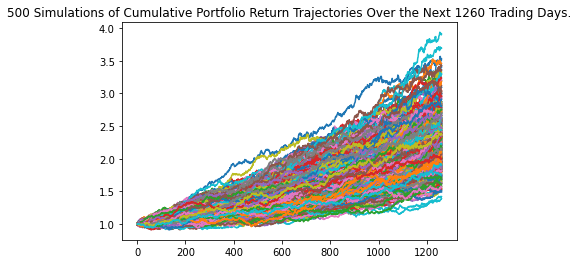

In [54]:
# Plot simulation outcomes
line_plot = MC_five_year.plot_simulation()

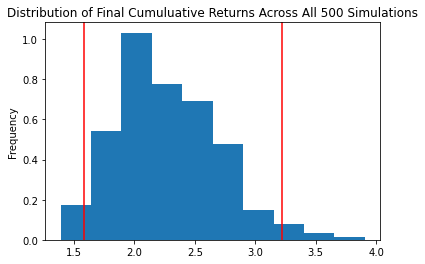

In [56]:
# Plot probability distribution and confidence intervals
dist_plot = MC_five_year.plot_distribution()

In [57]:
# Fetch summary statistics from the Monte Carlo simulation results
tbl = MC_five_year.summarize_cumulative_return()

# Print summary statistics
print(tbl)

count           500.000000
mean              2.270211
std               0.421742
min               1.389406
25%               1.950983
50%               2.222024
75%               2.545615
max               3.906742
95% CI Lower      1.585422
95% CI Upper      3.219374
Name: 1260, dtype: float64


In [59]:
# Set initial investment
initial_investment = 20000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
ci_lower_five = round(tbl[8]*initial_investment,2)
ci_upper_five = round(tbl[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 5 years will end within in the range of"
      f" ${ci_lower_five} and ${ci_upper_five}")

There is a 95% chance that an initial investment of $20000 in the portfolio over the next 5 years will end within in the range of $31708.44 and $64387.48


### Ten Years Retirement Option

In [60]:
# Configuring a Monte Carlo simulation to forecast 10 years cumulative returns
MC_ten_year = MCSimulation(
    portfolio_data = df_stock_data,
    weights = [.40,.60],
    num_simulation = 500,
    num_trading_days = 252*10
)

In [61]:
# Running a Monte Carlo simulation to forecast 10 years cumulative returns
MC_ten_year.portfolio_data.head()

AGG                                       \
                             open      high       low   close   volume   
time                                                                     
2020-12-07 00:00:00-05:00  117.76  117.8262  117.6900  117.75  4689469   
2020-12-08 00:00:00-05:00  117.88  117.9597  117.7500  117.77  3587353   
2020-12-09 00:00:00-05:00  117.73  117.7800  117.5172  117.62  4720359   
2020-12-10 00:00:00-05:00  117.74  117.9300  117.6900  117.88  4694024   
2020-12-11 00:00:00-05:00  118.01  118.0900  117.9500  118.03  5537449   

                                           SPY                              \
                          daily_return    open      high     low     close   
time                                                                         
2020-12-07 00:00:00-05:00          NaN  369.02  369.6200  367.72  369.1200   
2020-12-08 00:00:00-05:00     0.000170  367.72  370.7800  367.67  370.1599   
2020-12-09 00:00:00-05:00    -0.001274  370.88  371.0500  365.95  366.8900   
2020-12-10 00:00:00-05:00     0.002211  365.37  367.8600  364.43  366.7200   
2020-12-11 00:00:00-05:00     0.001272  364.90  366.7402  363.26  366.2800   

                                                  
                             volume daily_return  
time                                              
2020-12-07 00:00:00-05:00  40456544          NaN  
2020-12-08 00:00:00-05:00  32702217     0.002817  
2020-12-09 00:00:00-05:00  60700254    -0.008834  
2020-12-10 00:00:00-05:00  47851654    -0.000463  
2020-12-11 00:00:00-05:00  47917103    -0.001200

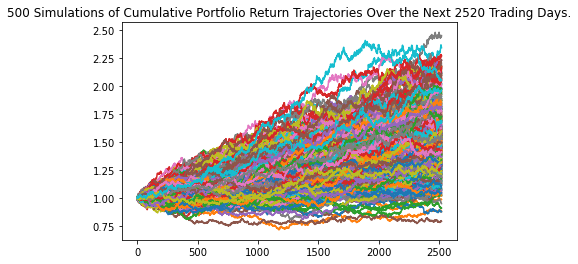

In [32]:
# Plot simulation outcomes
line_plot = MC_ten_year.plot_simulation()

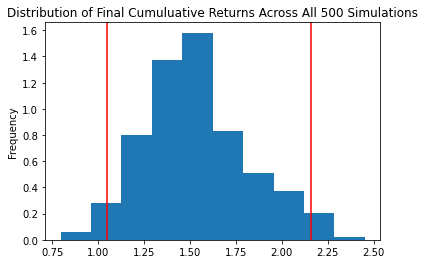

In [33]:
# Plot probability distribution and confidence intervals
dist_plot = MC_ten_year.plot_distribution()

In [34]:
# Fetch summary statistics from the Monte Carlo simulation results
tbl = MC_ten_year.summarize_cumulative_return()


# Print summary statistics
print(tbl)

count           500.000000
mean              1.537014
std               0.282192
min               0.795263
25%               1.339641
50%               1.523799
75%               1.693927
max               2.451787
95% CI Lower      1.049781
95% CI Upper      2.159935
Name: 2520, dtype: float64


In [62]:
# Set initial investment
initial_investment = 20000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
ci_lower_ten = round(tbl[8]*initial_investment,2)
ci_upper_ten = round(tbl[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 10 years will end within in the range of"
      f" ${ci_lower_ten} and ${ci_upper_ten}")

There is a 95% chance that an initial investment of $20000 in the portfolio over the next 10 years will end within in the range of $31708.44 and $64387.48
